<a href="https://colab.research.google.com/github/Legacy560/MTLSA25-Sales-Forecasting-Project/blob/main/Cleaning%20and%20ARIMA/Sales_Forecasting_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Imports

In [2]:
# # Step 1: Upgrade numpy to a known compatible version
# !pip install numpy==1.24.4 --quiet

# # Step 2: Force reinstall pmdarima with no cache
# !pip uninstall -y pmdarima
# !pip install --no-cache-dir pmdarima --quiet
# !pip install --upgrade numpy
# !pip install --upgrade scipy
# !pip install --upgrade statsmodels



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as pl
import json
import os
import warnings
import dask.dataframe as dd
from statsmodels.tsa.stattools import adfuller
from keras.models import Model
from keras.layers import Input, Dense, LayerNormalization, Dropout
from keras.layers import MultiHeadAttention, Add, GlobalAveragePooling1D, Reshape
from keras.optimizers import Adam
# import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Data Aquisition

In [4]:
#!pip install kaggle

In [5]:
from google.colab import drive

drive.mount("/content/gdrive")



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
cd /content/gdrive/Shareddrives/MLTSA25-Sales-Forecasting/Project

/content/gdrive/Shareddrives/MLTSA25-Sales-Forecasting/Project


In [7]:
# envs = json.load(open("kaggle.json", "r"))
# os.environ["KAGGLE_USERNAME"] = envs['username']
# os.environ["KAGGLE_KEY"] = envs['key']

In [8]:
#!kaggle competitions download -c m5-forecasting-accuracy

In [9]:
#!unzip m5-forecasting-accuracy.zip

#Read in data

In [10]:
cal = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')
salesVal = pd.read_csv('sales_train_validation.csv')
display(cal.head())
display(salesVal.head())
display(prices.head())

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [11]:
cal.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [12]:
#type of column d in cal
cal.dtypes
#number missing items in cal
cal.isnull().sum()

#number of entries in cal
cal.shape

(1969, 14)

#Reshape sales data into long format.

This allows for us to merge the sales dataset with the calendar dataset. These datasets are large, however; and any operations will cause the Python session to crash. Thus, before we can do anything else, we need to deal with the storage and memory that these datasets take up.

In [13]:
#This code came from: https://www.kaggle.com/competitions/m5-forecasting-accuracy/data. I take no credit for it.

#Downcast in order to save memory
def downcast(df):

  '''
  Changes column types in the dataframe to reduce memory usage.
  Input:
    df (pandas dataframe): dataframe to be downcast.
  Output:
    df (pandas dataframe): dataframe with reduced memory usage.
  '''
  cols = df.dtypes.index.tolist()
  types = df.dtypes.values.tolist()
  for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
  return df

salesVal = downcast(salesVal)
prices = downcast(prices)
cal = downcast(cal)


In [14]:
salesValLong = salesVal.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                         var_name="d", value_name="units_sold").dropna()
#This gives us a column "d" containing each sales day. This is the same as the "d" column from calendar

In [15]:
display(salesVal.head())
display(salesValLong.head(20))
display(cal.head())
display(prices.head())

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [16]:
#Get size of these

In [17]:
#Check for missing values
display(salesValLong.isnull().sum())
display(cal.isnull().sum())
display(prices.isnull().sum())

,0
id,0
item_id,0
dept_id,0
cat_id,0
store_id,0
state_id,0
d,0
units_sold,0


,0
date,0
wm_yr_wk,0
weekday,0
wday,0
month,0
year,0
d,0
event_name_1,1807
event_type_1,1807
event_name_2,1964


,0
store_id,0
item_id,0
wm_yr_wk,0
sell_price,0


#Merging Datasets

In [18]:
#Merge with Calendar dataset
salesValLong1 = salesValLong.merge(cal, on="d", how="left")
display(salesValLong1.head())


,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [19]:
print(salesValLong1.shape)
print(cal.shape)
print(salesValLong.shape)

(58327370, 21)
(1969, 14)
(58327370, 8)


In [20]:
#Merge with prices dataset
salesFull = salesValLong1.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")


In [21]:

#dump the previous datasets
del salesValLong
del cal
del prices
del salesVal
del salesValLong1


In [22]:
downcast(salesFull) #See if this improves our memory

,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.980469
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.480469
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,3.980469
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,1.280273


In [23]:
salesFull.shape

(58327370, 22)

In [24]:
# Step 1: Filter for a single store: CA_1
df_CA_1 = salesFull[salesFull['store_id'] == 'CA_1']

# Step 2: Get unique item IDs sold at this store
unique_items = df_CA_1['item_id'].unique()

# Step 3: Randomly choose 10 items (fixed seed)
np.random.seed(42)
selected_items = np.random.choice(unique_items, size=10, replace=False)

# Step 4: Filter the full store dataset for those 10 items
subset_df_CA_1 = df_CA_1[df_CA_1['item_id'].isin(selected_items)].copy()


In [25]:
display(subset_df_CA_1.head(11))
display(subset_df_CA_1.tail())

,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
343,HOBBIES_1_352_CA_1_validation,HOBBIES_1_352,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1027,HOUSEHOLD_1_472_CA_1_validation,HOUSEHOLD_1_472,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4.820312
1173,HOUSEHOLD_2_077_CA_1_validation,HOUSEHOLD_2_077,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1444,HOUSEHOLD_2_349_CA_1_validation,HOUSEHOLD_2_349,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4.468750
1517,HOUSEHOLD_2_422_CA_1_validation,HOUSEHOLD_2_422,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1961,FOODS_2_135_CA_1_validation,FOODS_2_135,FOODS_2,FOODS,CA_1,CA,d_1,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.460938
2083,FOODS_2_257_CA_1_validation,FOODS_2_257,FOODS_2,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2369,FOODS_3_145_CA_1_validation,FOODS_3_145,FOODS_3,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2663,FOODS_3_439_CA_1_validation,FOODS_3_439,FOODS_3,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2676,FOODS_3_452_CA_1_validation,FOODS_3_452,FOODS_3,FOODS,CA_1,CA,d_1,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,5.261719


,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58298841,FOODS_2_135_CA_1_validation,FOODS_2_135,FOODS_2,FOODS,CA_1,CA,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.480469
58298963,FOODS_2_257_CA_1_validation,FOODS_2_257,FOODS_2,FOODS,CA_1,CA,d_1913,2,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,1.000000
58299249,FOODS_3_145_CA_1_validation,FOODS_3_145,FOODS_3,FOODS,CA_1,CA,d_1913,1,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.980469
58299543,FOODS_3_439_CA_1_validation,FOODS_3_439,FOODS_3,FOODS,CA_1,CA,d_1913,6,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.980469
58299556,FOODS_3_452_CA_1_validation,FOODS_3_452,FOODS_3,FOODS,CA_1,CA,d_1913,1,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,4.980469


In [26]:
univariate_df_CA_1 = subset_df_CA_1[['id', 'units_sold']].copy()
display(univariate_df_CA_1.head())
display(univariate_df_CA_1.tail())

,id,units_sold
343,HOBBIES_1_352_CA_1_validation,0
1027,HOUSEHOLD_1_472_CA_1_validation,0
1173,HOUSEHOLD_2_077_CA_1_validation,0
1444,HOUSEHOLD_2_349_CA_1_validation,0
1517,HOUSEHOLD_2_422_CA_1_validation,0


,id,units_sold
58298841,FOODS_2_135_CA_1_validation,0
58298963,FOODS_2_257_CA_1_validation,2
58299249,FOODS_3_145_CA_1_validation,1
58299543,FOODS_3_439_CA_1_validation,6
58299556,FOODS_3_452_CA_1_validation,1


Get some statistics

In [27]:
univariate_df_CA_1.describe()

,units_sold
count,19130.000000
mean,0.654051
std,1.360183
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,16.000000


In [28]:
#Check for missing values in full dataset
display(univariate_df_CA_1.isnull().sum())

,0
id,0
units_sold,0


# Pivoting the dataframe from long format to wide format

In [29]:
# Step 1: Sort by 'd' to ensure order
subset_df_CA_1 = subset_df_CA_1.sort_values('d').reset_index(drop=True)

# Step 2: Extract the list of item IDs (order is important!)
item_ids = subset_df_CA_1['id'].unique()

# Step 3: Create a dictionary to hold time series per item
ts_dict = {}

for i, item_id in enumerate(item_ids):
    ts = subset_df_CA_1.iloc[i::len(item_ids)]['units_sold'].values  # every 10th row starting at i
    ts_dict[item_id] = ts

# Step 4: Convert to DataFrame for wide format (items as rows, time as columns)
import pandas as pd

wide_df = pd.DataFrame(ts_dict).T  # transpose to get [item x time]
wide_df.columns = [f'd_{i+1}' for i in range(wide_df.shape[1])]

# Step 5: Confirm shape
display(wide_df.head())
display(wide_df.tail())

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
HOBBIES_1_352_CA_1_validation,0,0,2,0,5,0,4,0,1,0,...,0,6,2,0,0,0,3,0,0,2
FOODS_3_452_CA_1_validation,1,0,0,0,0,4,0,2,0,1,...,1,0,0,2,0,2,1,0,2,0
FOODS_3_145_CA_1_validation,0,0,3,0,5,5,2,1,0,0,...,0,2,0,0,1,0,1,1,0,0
FOODS_2_257_CA_1_validation,0,1,2,1,0,0,0,0,0,0,...,0,3,3,1,2,3,4,0,0,0
FOODS_2_135_CA_1_validation,1,0,0,0,2,0,0,0,0,0,...,3,1,0,3,0,0,0,5,0,0


,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
FOODS_3_439_CA_1_validation,0,0,0,0,0,0,1,1,0,0,...,0,0,1,2,0,0,0,0,0,0
HOUSEHOLD_2_349_CA_1_validation,0,0,0,1,1,2,0,0,0,0,...,2,0,0,0,0,2,0,1,0,2
HOUSEHOLD_2_077_CA_1_validation,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,2,0,0
HOUSEHOLD_1_472_CA_1_validation,0,0,0,1,0,0,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
HOUSEHOLD_2_422_CA_1_validation,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,2


from matplotlib import pyplot as plt
_df_0['d_2'].plot(kind='hist', bins=20, title='d_2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['d_3'].plot(kind='hist', bins=20, title='d_3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['d_4'].plot(kind='hist', bins=20, title='d_4')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['d_5'].plot(kind='hist', bins=20, title='d_5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='d_2', y='d_3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='d_3', y='d_4', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='d_4', y='d_5', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='d_5', y='d_6', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['d_1']
  ys = series['d_2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('d_1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('d_1')
_ = plt.ylabel('d_2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['d_1']
  ys = series['d_3']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('d_1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('d_1')
_ = plt.ylabel('d_3')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['d_1']
  ys = series['d_4']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('d_1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('d_1')
_ = plt.ylabel('d_4')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['d_1']
  ys = series['d_5']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('d_1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('d_1')
_ = plt.ylabel('d_5')

from matplotlib import pyplot as plt
_df_12['d_2'].plot(kind='line', figsize=(8, 4), title='d_2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['d_3'].plot(kind='line', figsize=(8, 4), title='d_3')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['d_4'].plot(kind='line', figsize=(8, 4), title='d_4')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['d_5'].plot(kind='line', figsize=(8, 4), title='d_5')
plt.gca().spines[['top', 'right']].set_visible(False)

# Transformer Model with Tokenization

In [30]:
def tokenize_univariate_series(
    wide_df,             # DataFrame of shape [num_series, num_days]
    token_size=56,
    output_len=28,
    stride=1
):
    X_train, Y_train = [], []
    X_val, Y_val = [], []

    num_days = wide_df.shape[1]
    train_end = num_days - output_len  # day index 1885 if num_days = 1913

    for _, series in wide_df.iterrows():
        values = series.values.astype(np.float32)

        # Training tokens
        for start in range(0, train_end - token_size + 1, stride):
            end = start + token_size
            x = values[start:end]
            y = values[end:end + output_len]
            X_train.append(x)
            Y_train.append(y)

        # Validation token: last `token_size` days before d_1886
        x_val = values[train_end - token_size:train_end]
        y_val = values[train_end:train_end + output_len]
        X_val.append(x_val)
        Y_val.append(y_val)

    # Convert to NumPy arrays
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)

    # Print diagnostics
    print(f"Tokenization complete.")
    print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
    print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

    return X_train, Y_train, X_val, Y_val


In [31]:
token_size = 56
stride = 1
X_train, Y_train, X_val, Y_val = tokenize_univariate_series(
    wide_df=wide_df,
    token_size=token_size,
    output_len=28,
    stride=stride  # change to 56 for non-overlapping tokens
)

Tokenization complete.
X_train shape: (18300, 56), Y_train shape: (18300, 28)
X_val shape: (10, 56), Y_val shape: (10, 28)


In [32]:
print("NaNs in X_train:", np.isnan(X_train).any())
print("NaNs in Y_train:", np.isnan(Y_train).any())
print("NaNs in X_val:", np.isnan(X_val).any())
print("NaNs in Y_val:", np.isnan(Y_val).any())

print("Infs in X_train:", np.isinf(X_train).any())
print("Infs in Y_train:", np.isinf(Y_train).any())

NaNs in X_train: False
NaNs in Y_train: False
NaNs in X_val: False
NaNs in Y_val: False
Infs in X_train: False
Infs in Y_train: False


In [33]:
X_train = X_train[..., np.newaxis]  # Now shape = (N, token_size, 1)
X_val = X_val[..., np.newaxis]


In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# 1. ReduceLROnPlateau: Lower learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# 2. EarlyStopping: Stop training if no improvement for too long
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# 3. ModelCheckpoint: Save the best model during training
checkpoint = ModelCheckpoint(
    filepath='content/best_transformer_model.keras',  # Keras format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [35]:
from tensorflow import keras
from tensorflow.keras import layers

# One encoder block with attention + pointwise feedforward
def transformer_block(
    x,
    input_shape,
    heads=8,
    key_dim=256,
    encoder_proj_dim=4,
    dropout_attention=0.25,
    dropout_projection=0.25,
):
    # Multi-head self-attention
    x0 = layers.MultiHeadAttention(num_heads=heads, key_dim=key_dim)(x, x)
    x0 = layers.Dropout(dropout_attention)(x0)
    x0 = layers.Add()([x, x0])
    x0 = layers.LayerNormalization()(x0)

    # Pointwise feedforward via Conv1D (position-wise dense layers)
    x1 = layers.Conv1D(filters=encoder_proj_dim, kernel_size=1, activation="relu")(x0)
    x1 = layers.Conv1D(filters=input_shape[-1], kernel_size=1, activation="relu")(x1)
    x1 = layers.Dropout(dropout_projection)(x1)
    x1 = layers.Add()([x0, x1])
    x1 = layers.LayerNormalization()(x1)

    return x1

# Full model builder
def build_transformer_forecasting_model(
    input_shape,            # e.g., (56, 1)
    encoder_blocks=2,       # number of transformer blocks
    feed_forward_units=[256],
    output_len=28           # number of forecast days
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Stack transformer blocks
    for _ in range(encoder_blocks):
        x = transformer_block(x, input_shape)

    # Pooling to collapse time dimension
    x = layers.GlobalAveragePooling1D()(x)

    # Final dense feedforward head
    for n in feed_forward_units:
        x = layers.Dense(n, activation="relu")(x)
        x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(output_len)(x)  # Output shape: [batch, output_len]
    model = keras.Model(inputs, outputs)
    return model

# For univariate input (units_sold), X_train.shape = [N, token_size, 1]
input_shape = (X_train.shape[1], X_train.shape[2])  # e.g., (56, 1)

transformer_model = build_transformer_forecasting_model(
    input_shape=input_shape,
    encoder_blocks=4,
    feed_forward_units=[256, 256],
    output_len=Y_train.shape[1]
)

transformer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

transformer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 56, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 56, 1)     │     14,337 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 1)     │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 56, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 56, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 56, 1)     │          5 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 56, 1)     │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 56, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 56, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 56, 1)     │     14,337 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 56, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 56, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 56, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 56, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 56, 1)     │          5 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 56, 1)     │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 56, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 56, 1)     │          2 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 130,916 (511.39 KB)

 Trainable params: 130,916 (511.39 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
transformer_model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=32,
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)


Epoch 1/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.1312 - mae: 0.6937
Epoch 1: val_loss improved from inf to 2.02602, saving model to content/best_transformer_model.keras
572/572 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - loss: 2.1311 - mae: 0.6938 - val_loss: 2.0260 - val_mae: 0.9595 - learning_rate: 0.0010
Epoch 2/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.8671 - mae: 0.8287
Epoch 2: val_loss improved from 2.02602 to 1.88752, saving model to content/best_transformer_model.keras
572/572 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - loss: 1.8671 - mae: 0.8288 - val_loss: 1.8875 - val_mae: 0.9913 - learning_rate: 0.0010
Epoch 3/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.8528 - mae: 0.8880
Epoch 3: val_loss improved from 1.88752 to 1.86289, saving model to content/best_transformer_model.keras
572/572 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - loss: 1.8528 - mae: 0.8880 - val_loss: 1.8629 - val_mae: 0.9990 - learning_rate: 0.0010
Epoch 4/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - 

In [37]:
history = transformer_model.history

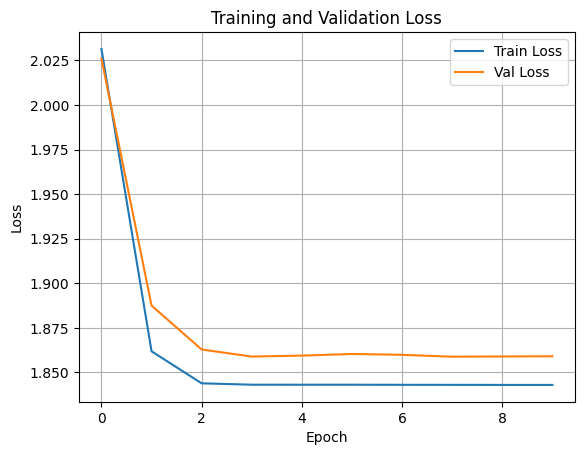

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# Make predictions on validation set
Y_pred = transformer_model.predict(X_val[..., np.newaxis])  # shape: [10, 28]

# Compute MSE and MAE manually for validation set
from sklearn.metrics import mean_squared_error, mean_absolute_error

for i in range(len(Y_val)):
    mse = mean_squared_error(Y_val[i], Y_pred[i])
    mae = mean_absolute_error(Y_val[i], Y_pred[i])
    print(f"Validation Sample {i + 1}: MSE = {mse:.4f}, MAE = {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
Validation Sample 1: MSE = 2.2872, MAE = 1.0665
Validation Sample 2: MSE = 0.9950, MAE = 0.8528
Validation Sample 3: MSE = 0.9446, MAE = 0.8275
Validation Sample 4: MSE = 2.1240, MAE = 1.0919
Validation Sample 5: MSE = 3.3359, MAE = 1.4072
Validation Sample 6: MSE = 0.5680, MAE = 0.6495
Validation Sample 7: MSE = 2.4350, MAE = 1.0678
Validation Sample 8: MSE = 0.4340, MAE = 0.6123
Validation Sample 9: MSE = 2.5439, MAE = 1.1739
Validation Sample 10: MSE = 2.9207, MAE = 1.2605


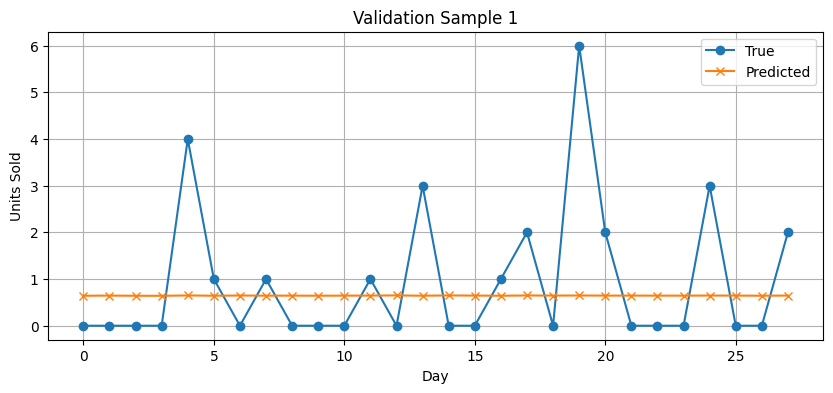

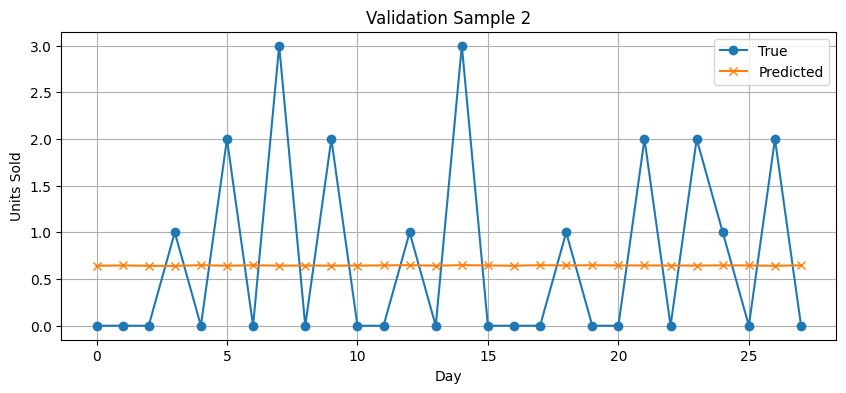

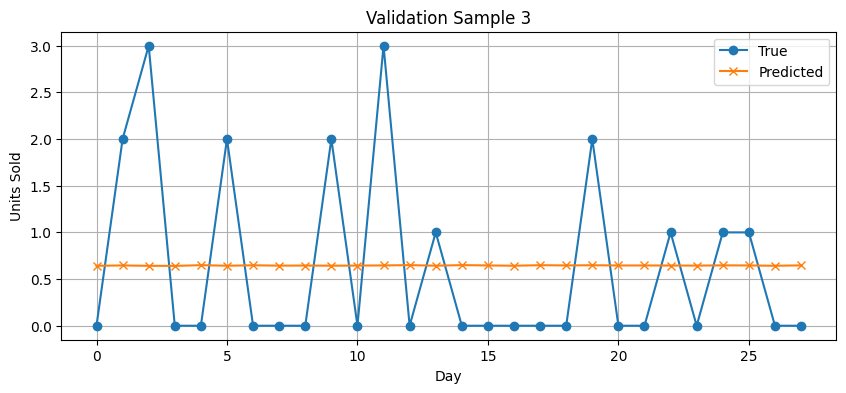

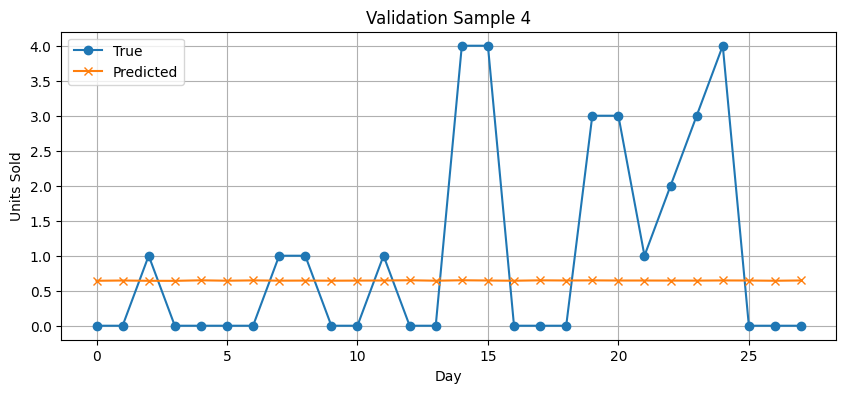

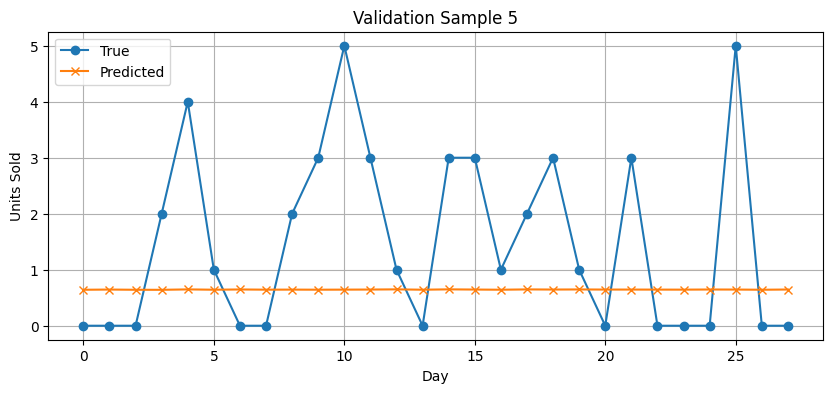

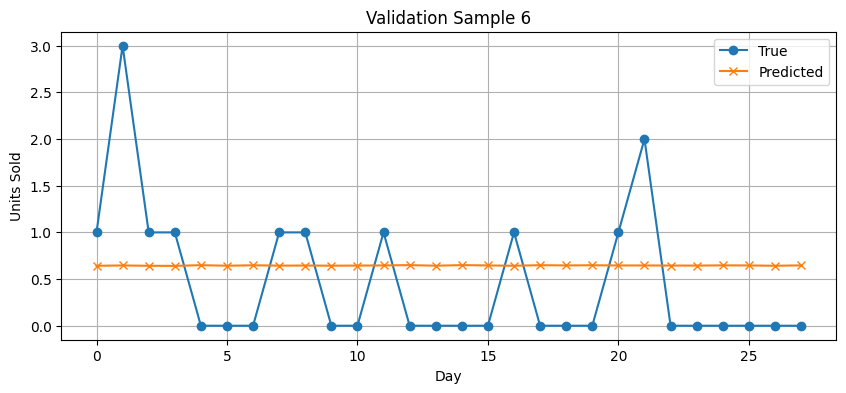

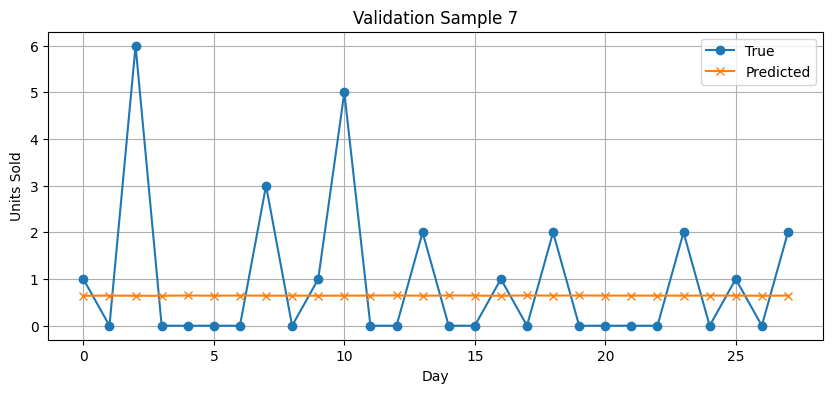

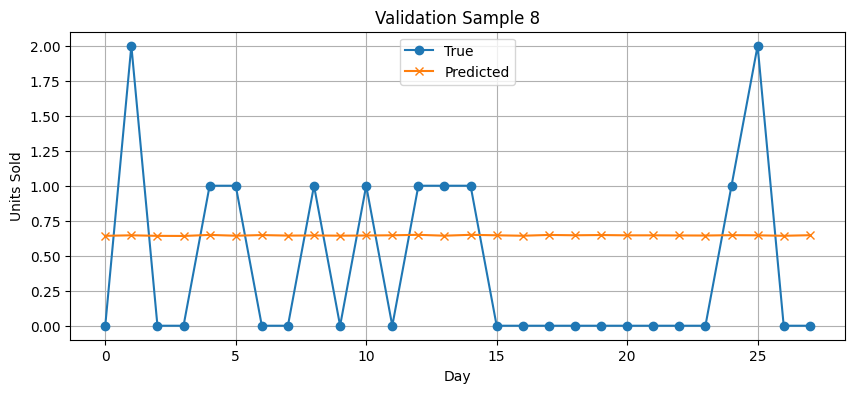

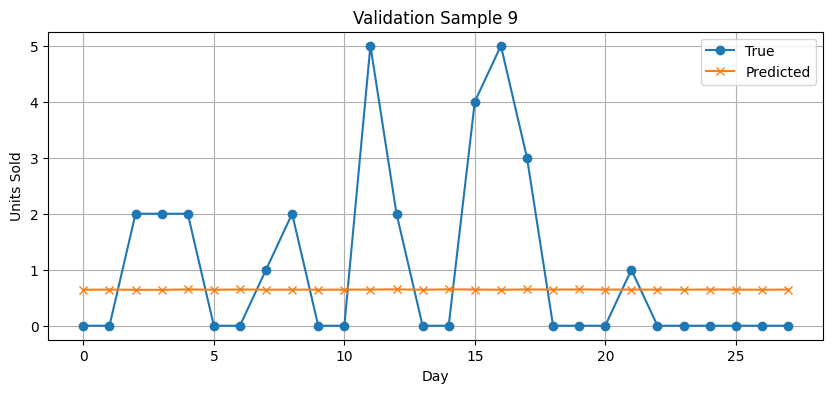

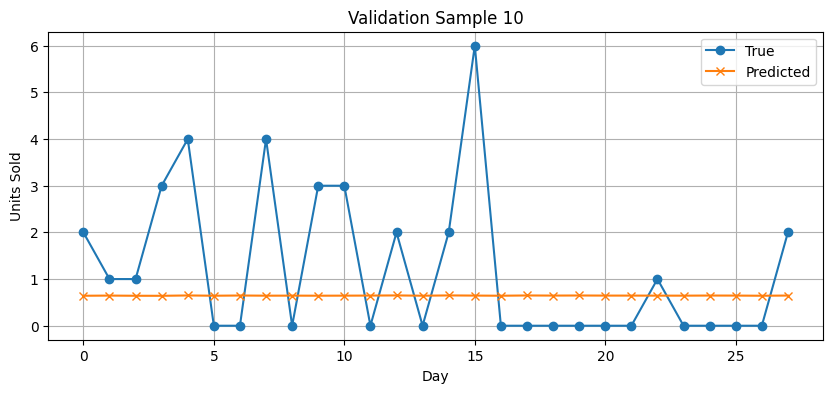

In [40]:
import matplotlib.pyplot as plt

# Plot a few example predictions
for i in range(min(Y_val.shape[0])):  # Use shape[0] to get the first dimension size
    plt.figure(figsize=(10, 4))
    plt.plot(range(28), Y_val[i], label='True', marker='o')
    plt.plot(range(28), Y_pred[i], label='Predicted', marker='x')
    plt.title(f"Validation Sample {i + 1}")
    plt.xlabel('Day')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

# Transformer Model without Tokenization

In [41]:
# # Constants
# INPUT_LEN = 1880   # Number of past days (encoder input)
# OUTPUT_LEN = 28  # Number of future days to predict (decoder output)
# N_PRODUCTS = 10  # Number of random products to use for now

# # Create storage
# X_train, Y_train = [], []
# X_val, Y_val = [], []

# # Select 10 random product IDs
# np.random.seed(42)
# product_ids = salesFull['id'].unique()
# selected_ids = np.random.choice(product_ids, N_PRODUCTS, replace=False)
# # selected_ids = product_ids

# # Loop through each selected product
# for pid in selected_ids:
#     df = salesFull[salesFull['id'] == pid].sort_values('date').reset_index(drop=True)

#     # Create (X, Y) training pairs using sliding window
#     for start in range(0, len(df) - INPUT_LEN - OUTPUT_LEN):
#         end = start + INPUT_LEN
#         x_seq = df.iloc[start:end]['units_sold'].values
#         y_seq = df.iloc[end:end + OUTPUT_LEN]['units_sold'].values
#         X_train.append(x_seq)
#         Y_train.append(y_seq)

#     # Final validation sample (last 56 days → next 28)
#     x_val = df.iloc[-(INPUT_LEN + OUTPUT_LEN):-OUTPUT_LEN]['units_sold'].values
#     y_val = df.iloc[-OUTPUT_LEN:]['units_sold'].values
#     X_val.append(x_val)
#     Y_val.append(y_val)

# # Convert to numpy arrays
# X_train = np.array(X_train)
# Y_train = np.array(Y_train)
# X_val = np.array(X_val)
# Y_val = np.array(Y_val)

# # Print shapes to verify
# print("X_train shape:", X_train.shape)  # [num_samples, 56]
# print("Y_train shape:", Y_train.shape)  # [num_samples, 28]
# print("X_val shape:", X_val.shape)      # [10, 56]
# print("Y_val shape:", Y_val.shape)      # [10, 28]


In [42]:
# from sklearn.preprocessing import StandardScaler, LabelEncoder

# # Create encoders
# event_enc = LabelEncoder()
# type_enc = LabelEncoder()
# # Replace MinMaxScaler with StandardScaler
# scaler_units = StandardScaler()
# scaler_price = StandardScaler()

# # Fit encoders (handle NaNs as "None")
# # Ensure columns are of type object before filling NaNs with new values
# salesFull['event_name_1'] = salesFull['event_name_1'].astype(str).fillna("None")
# salesFull['event_type_1'] = salesFull['event_type_1'].astype(str).fillna("None")
# salesFull['event_name_2'] = salesFull['event_name_2'].astype(str).fillna("None")
# salesFull['event_type_2'] = salesFull['event_type_2'].astype(str).fillna("None")


# salesFull['event_name_1'] = event_enc.fit_transform(salesFull['event_name_1'])
# salesFull['event_type_1'] = type_enc.fit_transform(salesFull['event_type_1'])
# salesFull['event_name_2'] = event_enc.fit_transform(salesFull['event_name_2'])
# salesFull['event_type_2'] = type_enc.fit_transform(salesFull['event_type_2'])


# # Normalize continuous features
# salesFull['sell_price'] = scaler_price.fit_transform(salesFull[['sell_price']])
# salesFull['units_sold'] = scaler_units.fit_transform(salesFull[['units_sold']])

# # Feature columns to use (excluding date, d, id)
# feature_cols = [
#     'units_sold', 'sell_price', 'snap_CA', 'snap_TX', 'snap_WI',
#     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
#     'wday', 'month'
# ]

# # Rebuild sequences
# X_train, Y_train = [], []
# X_val, Y_val = [], []

# for pid in selected_ids:
#     df = salesFull[salesFull['id'] == pid].sort_values('date').reset_index(drop=True)

#     for start in range(0, len(df) - INPUT_LEN - OUTPUT_LEN):
#         end = start + INPUT_LEN
#         x_seq = df.iloc[start:end][feature_cols].values
#         y_seq = df.iloc[end:end + OUTPUT_LEN]['units_sold'].values
#         X_train.append(x_seq)
#         Y_train.append(y_seq)

#     x_val = df.iloc[-(INPUT_LEN + OUTPUT_LEN):-OUTPUT_LEN][feature_cols].values
#     y_val = df.iloc[-OUTPUT_LEN:]['units_sold'].values
#     X_val.append(x_val)
#     Y_val.append(y_val)

# X_train = np.array(X_train)
# Y_train = np.array(Y_train)
# X_val = np.array(X_val)
# Y_val = np.array(Y_val)

# print("X_train shape:", X_train.shape)  # [N, 56, F]
# print("Y_train shape:", Y_train.shape)  # [N, 28]


In [43]:
# print("NaNs in X_train:", np.isnan(X_train).any())
# print("NaNs in Y_train:", np.isnan(Y_train).any())
# print("NaNs in X_val:", np.isnan(X_val).any())
# print("NaNs in Y_val:", np.isnan(Y_val).any())

# print("Infs in X_train:", np.isinf(X_train).any())
# print("Infs in Y_train:", np.isinf(Y_train).any())

In [44]:
# # Drop column index 1 from all input arrays (X_train, X_val)
# X_train = np.delete(X_train, 1, axis=2)
# X_val = np.delete(X_val, 1, axis=2)

# print("New X_train shape:", X_train.shape)
# print("New X_val shape:", X_val.shape)


In [45]:
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow.keras.backend as K

# def transformer_block(
#     x,
#     input_shape,
#     heads=8,
#     key_dim=256,
#     encoder_proj_dim=4,
#     dropout_attention=0.25,
#     dropout_projection=0.25,
# ):
#     x0 = layers.MultiHeadAttention(num_heads=heads, key_dim=key_dim)(x, x)
#     x0 = layers.Dropout(dropout_attention)(x0)
#     x0 = layers.Add()([x, x0])
#     x0 = layers.LayerNormalization()(x0)

#     x1 = layers.Conv1D(filters=encoder_proj_dim, kernel_size=1, activation="relu")(x0)
#     x1 = layers.Conv1D(filters=input_shape[-1], kernel_size=1, activation="relu")(x1)
#     x1 = layers.Dropout(dropout_projection)(x1)
#     x1 = layers.Add()([x0, x1])
#     x1 = layers.LayerNormalization()(x1)

#     return x1

# def build_transformer_forecasting_model(
#     input_shape,
#     encoder_blocks=2,
#     feed_forward_units=[256],
#     output_len=28
# ):
#     inputs = keras.Input(shape=input_shape)
#     x = inputs

#     for _ in range(encoder_blocks):
#         x = transformer_block(x, input_shape)

#     x = layers.GlobalAveragePooling1D()(x)
#     for n in feed_forward_units:
#         x = layers.Dense(n, activation="relu")(x)
#         x = layers.Dropout(0.4)(x)

#     outputs = layers.Dense(output_len)(x)  # Linear output for regression
#     model = keras.Model(inputs, outputs)
#     return model

# # Build and compile the model
# input_shape = (INPUT_LEN, X_train.shape[-1])  # time steps = 56, features = 10
# transformer_model = build_transformer_forecasting_model(input_shape)

# # def sparse_weighted_mse(min_val, weight_non_min=5.0):
# #     def loss_fn(y_true, y_pred):
# #         is_min = K.cast(K.less_equal(y_true, min_val + 1e-6), K.floatx())  # handles numerical noise
# #         weights = 1.0 + (1.0 - is_min) * (weight_non_min - 1.0)
# #         return K.mean(weights * K.square(y_true - y_pred))
# #     return loss_fn

# transformer_model.compile(
#     loss='mse',
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     metrics=["mae"]
# )

# transformer_model.summary()


In [46]:
# transformer_model.fit(
#     X_train,
#     Y_train,
#     validation_data=(X_val, Y_val),
#     epochs=50,
#     batch_size=32,
#     callbacks=[reduce_lr, early_stop, checkpoint],
#     verbose=1
# )
